# Overview of respiration data preprocessing and analysis
This tutorial covers a basic pipeline for preprocessing and analysis of respiration data collected during a experimental task. It introduces core `pyriodic` classes.


At first, we import the necessary Python modules:

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from pyriodic.preproc import RawSignal
from pyriodic.viz import plot_phase_diagnostics, CircPlot
from pyriodic.phase_events import create_phase_events

## Load in data and create `RawSignal` object

The first step is to load in the respiration time series data. Together with the sampling frequency, this is used to create a `RawSignal` object. This object holds many useful methods for preprocessing the raw data. 


In [53]:
# load data
from bioread import read_file
data = read_file("../../data/respiration/example.acq")

# extract respiration channel and sampling rate
sfreq = data.samples_per_second
print(f"Sampling rate: {sfreq} Hz")

t, resp_ts = data.time_index, data.channels[0].data
print(f"Data length: {len(resp_ts)/sfreq/60:.2f} minutes")

# initialise RawSignal object
raw = RawSignal(resp_ts, fs=sfreq)

Sampling rate: 1000.0 Hz
Data length: 48.36 minutes


The `RawSignal` object has a built-in plotting method that allows you to visualise the data. You can specify the start time and duration of the segment you want to plot. If no arguments are provided, it will plot the first 20 seconds of the signal. 

<Axes: xlabel='Time (s)', ylabel='Amplitude'>

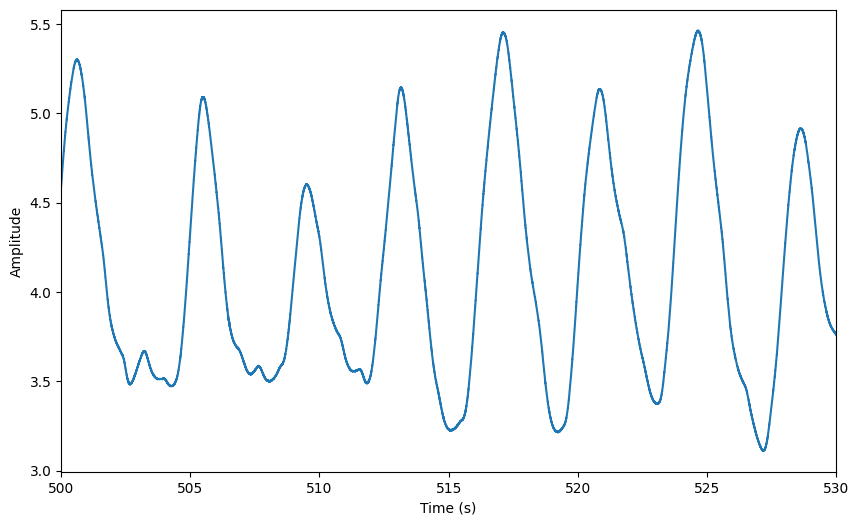

In [54]:
preproc_plot_kwargs = {
    "start": 500,
    "duration": 30,
}

raw.plot(**preproc_plot_kwargs)


## Preprocessing


<Axes: xlabel='Time (s)', ylabel='Amplitude'>

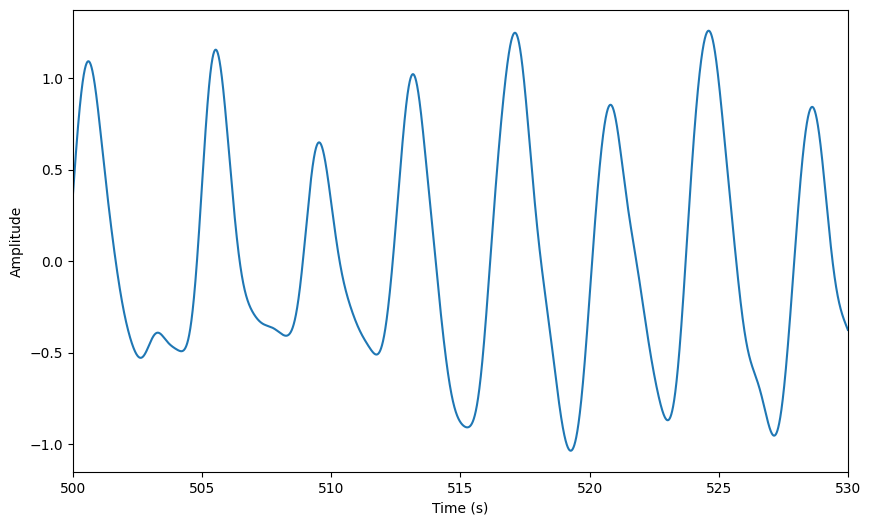

In [55]:
raw.filter_bandpass(low = 0.1, high = 1)
raw.plot(**preproc_plot_kwargs)

<Axes: xlabel='Time (s)', ylabel='Amplitude'>

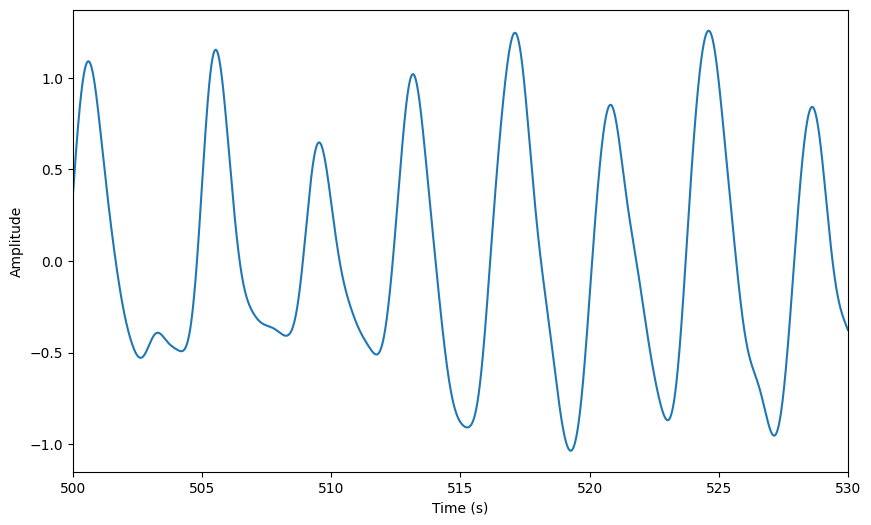

In [56]:
raw.smoothing(window_size=50)
raw.plot(**preproc_plot_kwargs)

<Axes: xlabel='Time (s)', ylabel='Amplitude'>

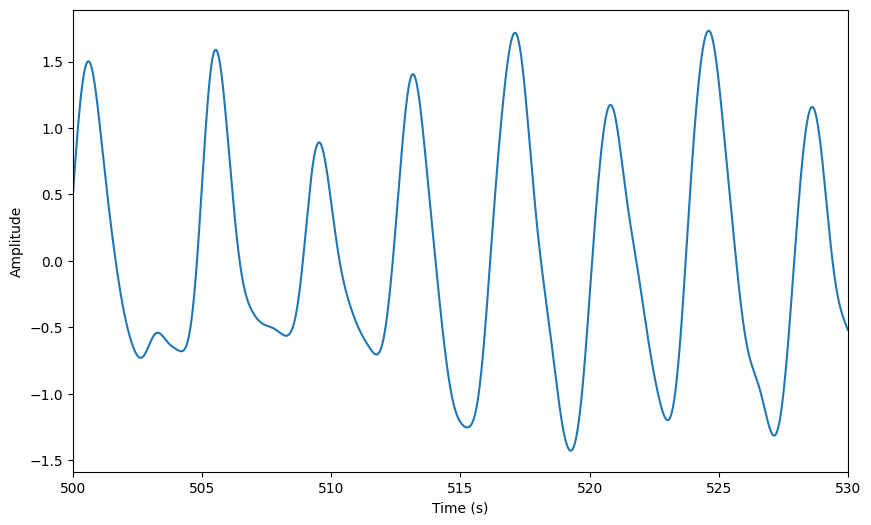

In [57]:
raw.zscore()
raw.plot(**preproc_plot_kwargs)

As the data is modified in-place, the original signal is lost. If you want to keep the original signal, make a copy before applying any modifications. To see which modifications have been applied to the signal, you can print the history:

In [58]:
raw.history

['bandpass(0.1 Hz - 1 Hz)',
 'Smoothing has been applied with a window size of 50',
 'zscore()']

## Extract phase angles
There are several ways to extract phase angles from the respiration signal. We will use the recommended two-point method, which linearly interpolates the signal from peak to trough from $0$ to $\pi$. and trough to peak from $\pi$ to $2\pi$.

For a review of the different methods, see the [phase extraction tutorial](02_phase_extraction.ipynb).

In [59]:
phase, peaks, troughs = raw.phase_twopoint(
    prominence=0.5,  # play around with these parameters if the peak detection is not satisfactory
    distance=0.5
    )

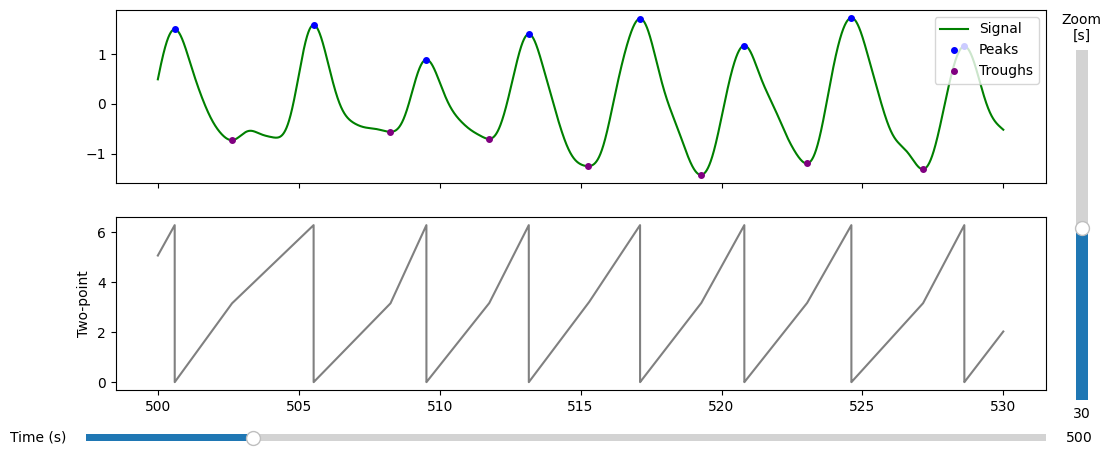

(<Figure size 1200x500 with 4 Axes>,
 array([<Axes: >, <Axes: ylabel='Two-point'>], dtype=object))

In [60]:
plot_phase_diagnostics(
            {"Two-point": phase},
            start = 500,
            window_duration = 30,
            fs = raw.fs,
            data = raw.ts, #the preproccessed data 
            peaks=peaks,
            troughs=troughs
        )

Now, we will extract the phase angles corresponding to the events of interest. This will allow us to analyse the whether the respiration phase is aligned with the timing of the stimuli presented during the task. 

To acheive this, we first need to get the event timings. In the data used for this tutorial, the events are stored in a numpy array with $n$ rows and 3 columns. The first column holds the the sample index of the event, and the third column holds the trigger value (i.e. an integer that identifes the type of event).

In [61]:
events = np.load("../../data/respiration/example_events.npy")

trigger_vals = events[:, 2]
sample_indices = events[:, 0]

print("Triggers:", trigger_vals[:10])
print("Sample indices:", sample_indices[:10])

Triggers: [254   1   1   1  10  56   1   1   1  10]
Sample indices: [ 99069  99085 100557 102004 103453 104126 104911 106362 107821 109277]


To make it easier to understand the data, we will convert the trigger values into a list of event labels.

In [62]:
event_ids = {
    # 3 salient stimuli leading up to the target
    1: 'stim/salient', 
    
    # target can be presented at two locations (middle vs. index finger)
    6: 'target/middle', 
    10: 'target/index',

    # responses can be correct vs. incorrect
    56: 'response/index/correct', 
    84: 'response/middle/incorrect', 
    52: 'response/middle/correct', 
    88: 'response/index/incorrect',

    # experiment control events 
    128:'break/start', 
    129: 'break/end', 
    254: 'experiment/start', 
    255: 'experiment/end'
}

event_labels = [event_ids[trig] for trig in trigger_vals]


In [63]:
np.unique(trigger_vals)
unique_labels = np.unique(event_labels)
print("Unique event labels:", len(unique_labels))


Unique event labels: 11


Now that we have our event labels and the phase angles, we can find the phase angles corresponding to the experimental events.

In [64]:
circ = create_phase_events(
    phase_ts=phase,
    events=sample_indices,
    event_labels=np.array(event_labels),
    rejection_method = 'segment_duration_sd', # excludes events during inspiration/exiration segments whose durations deviate more than `rejection_criterion` standard deviations from the mean
    rejection_criterion = 3
)

Rejected 114 out of 2053 events (5.6%)


The `Circular` object has a plotting function, so we can visualise the phase angles at the time of the events. This will allow us to see how the phase angles are distributed across the different event types.

Plotting label: break/end with 3 events
Plotting label: break/start with 3 events
Plotting label: experiment/end with 1 events
Plotting label: experiment/start with 1 events
Plotting label: response/index/correct with 149 events
Plotting label: response/index/incorrect with 40 events
Plotting label: response/middle/correct with 144 events
Plotting label: response/middle/incorrect with 27 events
Plotting label: stim/salient with 1178 events
Plotting label: target/index with 204 events
Plotting label: target/middle with 189 events


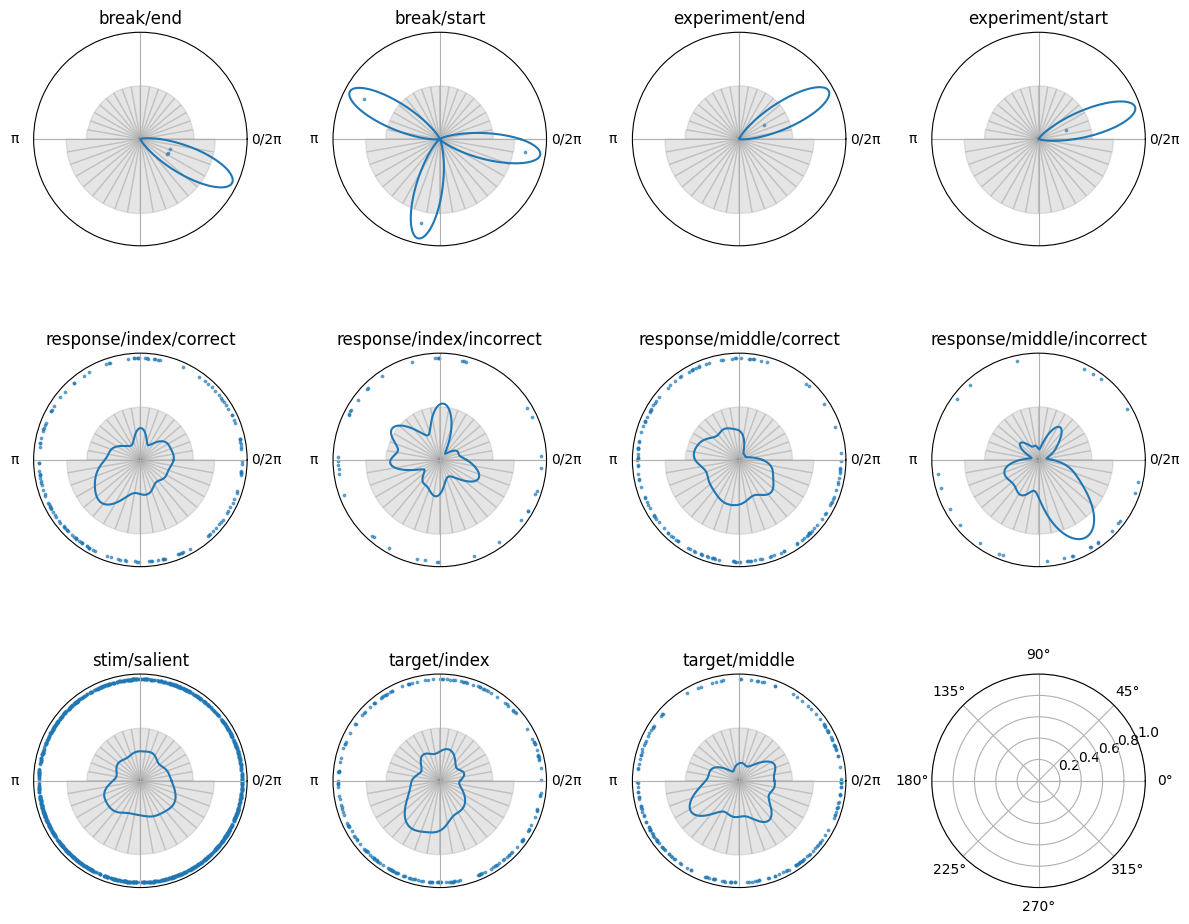

In [65]:
# find unique labels
unique_labels = np.unique(circ.labels)

fig, axes = plt.subplots(
    3, 4, 
    figsize=(12, 10), 
    subplot_kw={'projection': 'polar'}, 
)

for ax, label in zip(axes.flatten(), unique_labels):
    print(f"Plotting label: {label} with {np.sum(circ.labels==label)} events")
    circplot_tmp = CircPlot(
        circ=circ[label],
        ax=ax,
        title=label
    )

    circplot_tmp.add_points(s = 3, alpha = 0.6)
    circplot_tmp.add_density()
    circplot_tmp.add_histogram(phase)

plt.tight_layout()
